In [1]:
!pip install python-geohash
!pip install pygeohash

  Preparing metadata (setup.py) ... done
  Created wheel for python-geohash: filename=python_geohash-0.8.5-cp311-cp311-linux_x86_64.whl size=41947 sha256=d77f64556042051bca93135d05632f68400f9ff8c952a5892ba049560b9e5f08
  Stored in directory: /root/.cache/pip/wheels/02/7a/f4/c27d535af1a4ad8c1112e1bf299d9d47b57fe0fa2a464e4795
Successfully built python-geohash
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.9 MB/s eta 0:00:00


In [26]:
import folium
import gc
import random
from pathlib import Path
from typing import Tuple, Optional
import numpy as np
from folium.plugins import MousePosition, MiniMap
from folium.features import DivIcon
from folium import LayerControl
from branca.element import Element
import pygeohash as pgh
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import glob
from datetime import datetime, timedelta
from google.colab  import drive
import geohash
import hashlib



In [7]:
# Define the starting month of the whole project.
original_date=datetime(2019, 1, 1)


# Define the pre disaster date range
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 6, 1)

# Base path
drive.mount('/content/drive')
myDriveFile = "/content/drive/MyDrive/CLIMATOY/"
base_path = myDriveFile + 'toy datasets/'

# # Region around Brookhaven and Mastic Beach
min_lat = 40.728352567124034
max_lat = 40.82784572793889
min_lon = -72.95011028894201
max_lon = -72.72004468171392

# Baltimore
min_lat, max_lat = 39.20, 39.40
min_lon, max_lon = -76.72, -76.50

def hash_user_id(user_id):
    return hashlib.sha256(str(user_id).encode()).hexdigest()[:10]


# Preprocessing Function

In [27]:
def link_device_trajectories_optimized(df, max_time_gap_seconds=3600, geohash_digit_tolerance=8):
    """
    Links device trajectories based on temporal proximity and geohash similarity.
    When a device ID disappears, finds the new device ID with the closest geohash match within the specified time window.
    Also handles the case of device ID shuffling:
      1. Before the function starts, it reads a JSON file (default: device_id_shuffle_map.json).
         If a device_id in df is found in this mapping (i.e., it's a new ID), it will be replaced with its original ID.
      2. During the linking process, if a device ID link is detected (i.e., original ID differs from new ID),
         the new-to-original ID pair will be added to the JSON mapping file.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing trajectory data with device_id, unix_time_1,
        unix_time_2, geohash_1, geohash_2
    max_time_gap_seconds : int
        Maximum allowed time gap between trajectories to be linked (in seconds)
    geohash_digit_tolerance : int
        Minimum number of matching digits required in geohash comparison

    Returns:
    --------
    pandas.DataFrame
        DataFrame with linked device IDs
    dict
        Mapping of device IDs that were linked
    """
    import numpy as np
    from collections import defaultdict
    import os
    import json

    # --- New: Load original-to-shuffled ID mapping from JSON and replace new IDs in df ---
    shuffle_file = "device_id_shuffle_map.json"
    if os.path.exists(shuffle_file):
        with open(shuffle_file, 'r') as f:
            shuffle_mapping = json.load(f)
        print(f"Loaded existing shuffle mapping from {shuffle_file}.")
    else:
        shuffle_mapping = {}
        print(f"No existing shuffle mapping found. Starting with an empty mapping.")

    # Replace new device IDs in df with original IDs using the loaded mapping
    df['device_id'] = df['device_id'].apply(lambda x: shuffle_mapping.get(x, x))

    # -----------------------------------------------------------------------------------

    print("Starting trajectory linking process...")
    print(f"Parameters: max_time_gap={max_time_gap_seconds}s, geohash_digits={geohash_digit_tolerance}")

    linked_df = df.copy()
    linked_df = linked_df.sort_values(['device_id', 'unix_time_1'])

    device_groups = linked_df.groupby('device_id')

    device_last_points = {}
    for device_id, group in device_groups:
        last_row = group.loc[group['unix_time_2'].idxmax()]
        device_last_points[device_id] = {
            'time': last_row['unix_time_2'],
            'geohash': last_row['geohash_2'],
            'last_seen_idx': last_row.name
        }

    device_first_points = {}
    for device_id, group in device_groups:
        first_row = group.loc[group['unix_time_1'].idxmin()]
        device_first_points[device_id] = {
            'time': first_row['unix_time_1'],
            'geohash': first_row['geohash_1'],
            'first_seen_idx': first_row.name
        }

    print(f"Identified last points for {len(device_last_points)} device IDs")
    print(f"Identified first points for {len(device_first_points)} device IDs")

    geohash_similarity_cache = {}
    def geohash_similarity(geohash1, geohash2):
        cache_key = (geohash1, geohash2)
        if cache_key in geohash_similarity_cache:
            return geohash_similarity_cache[cache_key]

        min_len = min(len(geohash1), len(geohash2))
        for i in range(min_len):
            if geohash1[i] != geohash2[i]:
                result = i
                geohash_similarity_cache[cache_key] = result
                return result
        result = min_len
        geohash_similarity_cache[cache_key] = result
        return result

    time_buckets = defaultdict(list)
    for device_id, first_point in device_first_points.items():
        time_bucket = first_point['time'] // max_time_gap_seconds
        time_buckets[time_bucket].append((device_id, first_point))

    linked_device_pairs = []
    unlinked_device_count = 0
    already_linked_new_devices = set()

    for device_id, last_point in device_last_points.items():
        last_time_bucket = last_point['time'] // max_time_gap_seconds
        relevant_buckets = [last_time_bucket, last_time_bucket + 1]

        best_match = None
        best_similarity = -1

        for bucket in relevant_buckets:
            if bucket not in time_buckets:
                continue

            for new_device_id, first_point in time_buckets[bucket]:
                if (new_device_id == device_id or
                    first_point['time'] <= last_point['time'] or
                    new_device_id in already_linked_new_devices):
                    continue

                time_diff = first_point['time'] - last_point['time']
                if time_diff > max_time_gap_seconds:
                    continue

                similarity = geohash_similarity(last_point['geohash'], first_point['geohash'])
                if similarity >= geohash_digit_tolerance and similarity > best_similarity:
                    best_match = new_device_id
                    best_similarity = similarity

        if best_match:
            linked_device_pairs.append((device_id, best_match))
            already_linked_new_devices.add(best_match)
        else:
            unlinked_device_count += 1

    print(f"Found {len(linked_device_pairs)} potential device links")
    print(f"Could not find suitable matches for {unlinked_device_count} device IDs")

    device_id_mapping = {}
    def find_root_device(device_id):
        path = []
        current = device_id
        while current in device_id_mapping:
            path.append(current)
            current = device_id_mapping[current]
        for node in path:
            device_id_mapping[node] = current
        return current

    for old_id, new_id in linked_device_pairs:
        device_id_mapping[new_id] = old_id

    all_device_ids = set(linked_df['device_id'].unique())
    root_mapping = {device_id: find_root_device(device_id) for device_id in all_device_ids}

    linked_df['linked_device_id'] = linked_df['device_id'].map(root_mapping).fillna(linked_df['device_id'])

    print("Trajectory linking completed")

    # --- New: Update JSON mapping file ---
    # For all new-to-original mappings where IDs differ, update shuffle_mapping
    for new_id, original_id in device_id_mapping.items():
        if new_id != original_id and new_id not in shuffle_mapping:
            shuffle_mapping[new_id] = original_id
    with open(shuffle_file, 'w') as f:
        json.dump(shuffle_mapping, f, indent=4)
    print(f"Updated shuffle mapping written to {shuffle_file}.")
    # -----------------------------------------------------------------------------------

    return linked_df, device_id_mapping

def process_and_filter_df(
    combined_df: pd.DataFrame,
    min_lat: float,
    max_lat: float,
    min_lon: float,
    max_lon: float,
    geohash_precision: int = 9,
    hash_func: Optional[callable] = None
) -> Tuple[pd.DataFrame, int, int]:
    """
    Filter a combined trajectory DataFrame by a geographic bounding box,
    compute geohashes, select and compute time columns, re‑encode device IDs,
    and report row & unique‑device counts.

    Parameters
    ----------
    combined_df : pd.DataFrame
        Input DataFrame with columns:
        ['device_id', 'linked_trip_id',
         'utc_timestamp_1', 'utc_offset_1',
         'utc_timestamp_2', 'utc_offset_2',
         'latitude_1', 'longitude_1',
         'latitude_2', 'longitude_2', …]
    min_lat, max_lat, min_lon, max_lon : float
        Geographic filters for latitude_2 / longitude_2.
    geohash_precision : int, default=9
        Precision to use when encoding geohashes.
    hash_func : callable or None
        Function to re‑encode `device_id`. If None, IDs are left unchanged.

    Returns
    -------
    filtered_df : pd.DataFrame
        Processed DataFrame with columns:
        ['device_id', 'original_device_id', 'linked_trip_id',
         'utc_timestamp_1', 'utc_offset_1', 'utc_timestamp_2', 'utc_offset_2',
         'latitude_1', 'longitude_1', 'geohash_1',
         'latitude_2', 'longitude_2', 'geohash_2',
         'unix_time_1', 'unix_time_2',
         'timestamp_1', 'timestamp_2',
         'datetime_1', 'date_1']
    total_rows : int
        Number of rows in `filtered_df`.
    total_unique_devices : int
        Number of unique `device_id` values in `filtered_df`.
    """
    # 1) Filter by region
    filter_mask = (
        (combined_df["latitude_2"] >= min_lat) & (combined_df["latitude_2"] <= max_lat)
        | (combined_df["longitude_2"] >= min_lon) & (combined_df["longitude_2"] <= max_lon)
    )
    filtered_df = combined_df[filter_mask].copy()
    print(f"Original DataFrame shape: {combined_df.shape}")
    print(f"Filtered DataFrame shape: {filtered_df.shape}")
    print(f"Dropped rows: {combined_df.shape[0] - filtered_df.shape[0]}")

    # 2) Encode geohashes
    filtered_df["geohash_1"] = filtered_df.apply(
        lambda row: geohash.encode(row["latitude_1"], row["longitude_1"], precision=geohash_precision),
        axis=1
    )
    filtered_df["geohash_2"] = filtered_df.apply(
        lambda row: geohash.encode(row["latitude_2"], row["longitude_2"], precision=geohash_precision),
        axis=1
    )

    # 3) Keep only necessary columns
    columns_to_keep = [
        'device_id',
        'linked_trip_id',
        'utc_timestamp_1',
        'utc_offset_1',
        'utc_timestamp_2',
        'utc_offset_2',
        'latitude_1',
        'longitude_1',
        'geohash_1',
        'latitude_2',
        'longitude_2',
        'geohash_2'
    ]
    filtered_df = filtered_df[columns_to_keep]

    # 4) Compute unix_time columns
    filtered_df['unix_time_1'] = (
        filtered_df['utc_timestamp_1'] + filtered_df['utc_offset_1']
    )
    filtered_df['unix_time_2'] = (
        filtered_df['utc_timestamp_2'] + filtered_df['utc_offset_2']
    )

    # 5) Generate human-readable timestamps
    def _unix_to_mdy_hms(ts: float) -> str:
        return datetime.fromtimestamp(ts).strftime('%m/%d/%Y %H:%M:%S')

    filtered_df['timestamp_1'] = filtered_df['unix_time_1'].apply(_unix_to_mdy_hms)
    filtered_df['timestamp_2'] = filtered_df['unix_time_2'].apply(_unix_to_mdy_hms)

    # 6) Preserve original device_id, then re‑hash if needed
    filtered_df['original_device_id'] = filtered_df['device_id']
    if hash_func is not None:
        filtered_df['device_id'] = filtered_df['device_id'].apply(hash_func)

    # 7) Convert to datetime and extract date
    filtered_df['datetime_1'] = pd.to_datetime(filtered_df['timestamp_1'])
    filtered_df['date_1'] = filtered_df['datetime_1'].dt.date

    # 8) Compute counts
    total_rows = len(filtered_df)
    total_unique_devices = filtered_df['device_id'].nunique()
    print(f"Processed rows: {total_rows}")
    print(f"Unique device IDs: {total_unique_devices}")

    return filtered_df, total_rows, total_unique_devices

def apply_residency_filter(df, min_lat, max_lat, min_lon, max_lon):

    in_box = (
        df['latitude_2'].between(min_lat, max_lat) &
        df['longitude_2'].between(min_lon, max_lon)
    )

    total_counts   = df['device_id'].value_counts()
    in_box_counts  = df[in_box]['device_id'].value_counts()

    stats = (
        pd.DataFrame({
            'total':   total_counts,
            'in_box':  in_box_counts
        })
        .fillna(0)
    )

    valid_devices = stats[ stats['in_box'] >= stats['total'] / 2].index

    return df[ df['device_id'].isin(valid_devices) ].copy()

def apply_residency_filter2(df, min_appearances=0):
    device_counts = df['device_id'].value_counts()

    valid_devices = device_counts[device_counts >= min_appearances].index
    filtered_df = df[df['device_id'].isin(valid_devices)].copy()

    return filtered_df

In [31]:
def detect_migrate(
    linked_df: pd.DataFrame,
    mapping_df: pd.DataFrame,
    min_lat: float,
    max_lat: float,
    min_lon: float,
    max_lon: float,
    days_threshold: int = 30
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Identify migrated devices and households.

    Device-level rule
    -----------------
    • If a device has not appeared *inside the geographic box* for more than
      `days_threshold` days, it is tagged as migrated.
    • A device that never appears in the trajectory data at all is *also*
      considered migrated.

    Household-level rule
    --------------------
    • A household is tagged as migrated only when *all* of its registered
      devices are migrated.

    Parameters
    ----------
    linked_df : pd.DataFrame
        Trajectory rows with columns:
        ['device_id', 'latitude_2', 'longitude_2', 'timestamp_2'].
    mapping_df : pd.DataFrame
        Device → household mapping, columns:
        ['home_geohash_8', 'device_id'].
    min_lat, max_lat, min_lon, max_lon : float
        Bounding-box limits that define the “region”.
    days_threshold : int, default 30
        Absence threshold in days.

    Returns
    -------
    moved_devices_df : pd.DataFrame
        ['device_id', 'last_in_region_date', 'days_since_last']
    moved_households_df : pd.DataFrame
        ['home_geohash_8', 'total_devices', 'moved_device_count']
    """
    # ------------------------------------------------------------------
    # 0. Pre-checks
    # ------------------------------------------------------------------
    if linked_df.empty:
        # No trajectory data at all → every mapped device / household is migrated
        overall_max = pd.Timestamp.today().date()
        overall_min = overall_max                           # dummy
    else:
        linked_df = linked_df.copy()
        linked_df['timestamp_2'] = pd.to_datetime(linked_df['timestamp_2'])
        linked_df['date'] = linked_df['timestamp_2'].dt.date
        overall_max = linked_df['date'].max()
        overall_min = linked_df['date'].min()

    # ------------------------------------------------------------------
    # 1. Keep only pings inside the region
    # ------------------------------------------------------------------
    if not linked_df.empty:
        region_mask = (
            (linked_df['latitude_2']  >= min_lat) & (linked_df['latitude_2'] <= max_lat) &
            (linked_df['longitude_2'] >= min_lon) & (linked_df['longitude_2'] <= max_lon)
        )
        in_region = linked_df[region_mask]
    else:
        in_region = linked_df  # empty

    # ------------------------------------------------------------------
    # 2. Devices WITH region visits → compute last date & absence
    # ------------------------------------------------------------------
    records_dev: list[dict] = []
    for dev, grp in in_region.groupby('device_id'):
        last_date   = grp['date'].max()
        days_since  = (overall_max - last_date).days
        if days_since > days_threshold:
            records_dev.append({
                'device_id':            dev,
                'last_in_region_date':  last_date,
                'days_since_last':      days_since
            })

    # Devices seen at least once in region (for later subtraction)
    seen_devs = set(in_region['device_id'].unique())

    # ------------------------------------------------------------------
    # 3. Devices that NEVER visited the region → also migrated
    # ------------------------------------------------------------------
    all_devs   = set(mapping_df['device_id'])
    never_seen = all_devs - seen_devs

    # duration from earliest observation in dataset; if dataset empty,
    # set to days_threshold+1 so they are always counted as migrated
    base_gap = (overall_max - overall_min).days if linked_df is not None and not linked_df.empty else days_threshold + 1

    for dev in never_seen:
        if base_gap > days_threshold:
            records_dev.append({
                'device_id':            dev,
                'last_in_region_date':  pd.NaT,
                'days_since_last':      base_gap
            })

    moved_devices_df = pd.DataFrame(records_dev)

    # ------------------------------------------------------------------
    # 4. Household-level aggregation
    # ------------------------------------------------------------------
    home_to_devices = (
        mapping_df.groupby('home_geohash_8')['device_id']
                  .apply(list)
                  .to_dict()
    )

    if moved_devices_df.empty:
        return moved_devices_df, moved_devices_df  # nothing moved

    moved_set = set(moved_devices_df['device_id'])
    records_home: list[dict] = []

    for home, dev_list in home_to_devices.items():
        total = len(dev_list)
        migrated = sum(d in moved_set for d in dev_list)
        if total > 0 and migrated == total:
            records_home.append({
                'home_geohash_8':     home,
                'total_devices':      total,
                'moved_device_count': migrated
            })

    moved_households_df = pd.DataFrame(records_home)

    return moved_devices_df, moved_households_df

def detect_vacant(
    linked_df: pd.DataFrame,
    mapping_df: pd.DataFrame,
    min_lat: float,
    max_lat: float,
    min_lon: float,
    max_lon: float,
    days_threshold: int = 30,
    geohash_precision: int = 8
) -> pd.DataFrame:
    """
    Detect vacant homes within a geographic region. A home is considered vacant if
    none of its devices have been physically present (exact geohash match) at the
    home geohash for more than `days_threshold` days. Homes that never appeared
    at home are also flagged as vacant.

    Parameters
    ----------
    linked_df : pd.DataFrame
        Trajectory data with columns ['device_id', 'latitude_2', 'longitude_2', 'timestamp_2'].
    mapping_df : pd.DataFrame
        Device-to-home mapping with columns ['home_geohash_8', 'device_id'].
    min_lat, max_lat, min_lon, max_lon : float
        Bounding box coordinates to filter the trajectories.
    days_threshold : int, default 30
        Number of days of absence to declare a home vacant.
    geohash_precision : int, default 8
        Precision to encode track geohashes.

    Returns
    -------
    pd.DataFrame
        Columns:
          - home_geohash_8: str
          - last_seen_date: datetime.date or NaT
          - days_since_last_seen: int
          - total_devices: int
    """
    # 1. Convert timestamps and extract dates
    df = linked_df.copy()
    df['timestamp_2'] = pd.to_datetime(df['timestamp_2'])
    df['date'] = df['timestamp_2'].dt.date
    overall_max = df['date'].max()

    # 2. Filter trajectories to the bounding box
    region_mask = (
        (df['latitude_2']  >= min_lat) & (df['latitude_2']  <= max_lat) &
        (df['longitude_2'] >= min_lon) & (df['longitude_2'] <= max_lon)
    )
    region_df = df[region_mask].copy()
    if region_df.empty:
        # No data in region → all mapped homes are vacant by default
        start_date = df['date'].min()
    else:
        start_date = region_df['date'].min()

    # 3. Associate each trajectory with its home
    region_df = region_df.merge(
        mapping_df[['device_id', 'home_geohash_8']],
        on='device_id',
        how='inner'
    )

    # 4. Encode each point to geohash and mark at_home
    region_df['track_geohash'] = region_df.apply(
        lambda r: pgh.encode(r['latitude_2'], r['longitude_2'], precision=geohash_precision),
        axis=1
    )
    region_df['at_home'] = region_df['track_geohash'] == region_df['home_geohash_8']

    # 5. Compute last_seen for homes that ever had at_home=True
    last_seen = (
        region_df[region_df['at_home']]
        .groupby('home_geohash_8')['date']
        .max()
    )

    # 6. Count total devices per home
    home_counts = mapping_df.groupby('home_geohash_8')['device_id'].nunique()

    # 7. Build vacancy records, including homes never seen at home
    records = []
    for home, total_devices in home_counts.items():
        if home in last_seen:
            last_date = last_seen[home]
            days_since = (overall_max - last_date).days
        else:
            # never seen at home
            last_date = pd.NaT
            days_since = (overall_max - start_date).days

        if days_since > days_threshold:
            records.append({
                'home_geohash_8':        home,
                'last_seen_date':        last_date,
                'days_since_last_seen':  days_since,
                'total_devices':         total_devices
            })

    return pd.DataFrame(records)

# Prepocessing

In [ ]:
# #Loading Data and do filtering based on study region
# dfs = []

# current_date = start_date
# while current_date <= end_date:
#     date_str = current_date.strftime('%Y%m%d')
#     parquet_file_path = f"{base_path}{date_str}/"

#     try:
#         print(f"Reading data for {date_str}...")
#         df_temp = pd.read_parquet(parquet_file_path, engine='pyarrow')

#         # Add a date column to keep track of the source date (optional)
#         df_temp['source_date'] = date_str
#         dfs.append(df_temp)
#         print(f"Successfully read data with shape: {df_temp.shape}")

#     except Exception as e:
#         print(f"Error reading data for {date_str}: {e}")

#     current_date += timedelta(days=1)

# # Check if we have any dataframes to concatenate
# if len(dfs) > 0:
#     combined_df = pd.concat(dfs, ignore_index=True)
#     print("\nCombined Dataframe Info:")
#     print(f"Shape: {combined_df.shape}")
#     print(f"Column Names: {combined_df.columns.tolist()}")
#     print("\nFirst 5 rows of combined data:")
#     print(combined_df.head(5))

#     combined_df.to_parquet(myDriveFile+"combined_data.parquet")
# else:
#     print("No data was read successfully.")

In [32]:
import pandas as pd
from pathlib import Path

# ------------------------------------------------------------------
# Main Run
# ------------------------------------------------------------------
# Folder that stores monthly parquet files, e.g. combined_data_2020-01.parquet
parquet_folder = myDriveFile

# Folder for e.g. user_home_relation_2020-01.csv
mapping_folder   = Path("home_tables/")
# Output folder
output_folder    = Path("household_states/")
output_folder.mkdir(exist_ok=True, parents=True)

# Months to process
# I assume each month has different parquet_file path name
months = [
    "2019-01",
    "2019-02",
    "2019-03",
    # add more months …
]


# ------------------------------------------------------------------
# MAIN LOOP
# ------------------------------------------------------------------
for month in months:
    print(f"Processing {month} …")

    # # 1. Load parquet of this month. T
    ### The name of this parquet_file should be moth related.
    parquet_file = parquet_folder + "combined_data.parquet"
    combined_df  = pd.read_parquet(parquet_file, engine="pyarrow")

    # 2. Run your preprocessing pipeline
    filtered_df, n_rows, n_devs = process_and_filter_df(
        combined_df,
        min_lat=min_lat, max_lat=max_lat,
        min_lon=min_lon, max_lon=max_lon,
        geohash_precision=8,
        hash_func=hash_user_id
    )
    filtered_df = apply_residency_filter(filtered_df, min_lat, max_lat, min_lon, max_lon)
    filtered_df = apply_residency_filter2(filtered_df)

    # 3. Link trajectories
    linked_df, _ = link_device_trajectories_optimized(
        filtered_df,
        max_time_gap_seconds=3600,
        geohash_digit_tolerance=8
    )

    # 4. Load device–home mapping for this month
    mapping_file = mapping_folder / f"user_home_relation_2019-01-01.csv"
    mapping_df   = pd.read_csv(mapping_file)

    # 5. Detect migration & vacancy
    moved_devs, moved_homes = detect_migrate(
        linked_df,
        mapping_df,
        min_lat, max_lat, min_lon, max_lon,
        days_threshold=20
    )
    vacant_df = detect_vacant(
        linked_df,
        mapping_df,
        min_lat, max_lat, min_lon, max_lon,
        days_threshold=20
    )

    # 6. Save results
    moved_homes.to_csv(output_folder / f"Migrated_home{month}.csv", index=False)
    vacant_df.to_csv(output_folder / f"Vacant_home{month}.csv",  index=False)

    print(f"   Migrated homes: {len(moved_homes):>4}  •  "
          f"Vacant homes: {len(vacant_df):>4}")
    del combined_df, filtered_df, linked_df, mapping_df, moved_devs, moved_homes, vacant_df
    gc.collect()

print("✅ All months processed and saved.")


Processing 2019-01 …
Original DataFrame shape: (5361762, 30)
Filtered DataFrame shape: (440644, 30)
Dropped rows: 4921118
Processed rows: 440644
Unique device IDs: 40616
Loaded existing shuffle mapping from device_id_shuffle_map.json.
Starting trajectory linking process...
Parameters: max_time_gap=3600s, geohash_digits=8
Identified last points for 6032 device IDs
Identified first points for 6032 device IDs
Found 0 potential device links
Could not find suitable matches for 6032 device IDs
Trajectory linking completed
Updated shuffle mapping written to device_id_shuffle_map.json.
   Migrated homes:   56  •  Vacant homes:  371
Processing 2019-02 …
Original DataFrame shape: (5361762, 30)
Filtered DataFrame shape: (440644, 30)
Dropped rows: 4921118
Processed rows: 440644
Unique device IDs: 40616
Loaded existing shuffle mapping from device_id_shuffle_map.json.
Starting trajectory linking process...
Parameters: max_time_gap=3600s, geohash_digits=8
Identified last points for 6032 device IDs
Id

# Generate Fake Social Network For Testing (Don't Run)

In [12]:
import pandas as pd
import random

# 1. Load the mapping of users to homes for the target date
mapping = pd.read_csv('home_tables/user_home_relation_2019-01-01.csv')  # adjust path if needed
# Extract unique households (take exactly 1000 if more)
all_homes = mapping['home_geohash_8'].unique().tolist()
homes = all_homes[:1000] if len(all_homes) >= 1000 else all_homes

# 2. Compute device count per household
home_device_count = mapping.groupby('home_geohash_8')['device_id'].nunique().to_dict()

# 3. Generate 5000 unique random links (undirected pairs)
edges_set = set()
while len(edges_set) < 5000:
    h1, h2 = random.sample(homes, 2)
    # enforce order to avoid duplicates (h1 < h2 lexicographically)
    if h1 > h2:
        h1, h2 = h2, h1
    edges_set.add((h1, h2))
edges = list(edges_set)

# 4. Assign types: 10% type=1, 90% type=0
num_edges = len(edges)
num_type1 = int(0.1 * num_edges)
type1_indices = set(random.sample(range(num_edges), num_type1))

# 5. Build the DataFrame
rows = []
for idx, (h1, h2) in enumerate(edges):
    rows.append({
        'home_1':         h1,
        'home_2':         h2,
        'link_count':     1,
        'num_possible':   1,
        'avg_link':       1.0,
        'type':           1 if idx in type1_indices else 0,
        'home_1_number':  home_device_count.get(h1, 1),
        'home_2_number':  home_device_count.get(h2, 1),
    })

df_network = pd.DataFrame(rows)

# 6. Save to CSV
output_file = 'Household_social_network_2019-01-01.csv'
df_network.to_csv(output_file, index=False)
print(f"Generated {len(df_network)} links and saved to {output_file}")
print(df_network.head())


Generated 5000 links and saved to Household_social_network_2019-01-01.csv
     home_1    home_2  link_count  num_possible  avg_link  type  \
0  dqcmw3c4  dqcx2kqk           1             1       1.0     1   
1  dqcr5v7p  dqcxb90t           1             1       1.0     1   
2  dqcx65w2  dqcx88nm           1             1       1.0     0   
3  dqcxdjjx  dr1817db           1             1       1.0     0   
4  dqcrnx10  dqcrrck5           1             1       1.0     0   

   home_1_number  home_2_number  
0              1              2  
1              1              1  
2              1              1  
3              1              1  
4              1              1  


# Visulization

household_states/Migrated_home2019-01.csv
household_states/Migrated_home2019-02.csv
household_states/Migrated_home2019-03.csv
household_states/Migrated_home2019-04.csv
household_states/Vacant_home2019-01.csv
household_states/Vacant_home2019-02.csv
household_states/Vacant_home2019-03.csv
household_states/Vacant_home2019-04.csv
[{'date': Timestamp('2019-01-01 00:00:00'), 'status': 'Migrated', 'count': 56}, {'date': Timestamp('2019-02-01 00:00:00'), 'status': 'Migrated', 'count': 48}, {'date': Timestamp('2019-03-01 00:00:00'), 'status': 'Migrated', 'count': 65}, {'date': Timestamp('2019-04-01 00:00:00'), 'status': 'Migrated', 'count': 98}, {'date': Timestamp('2019-01-01 00:00:00'), 'status': 'Vacant', 'count': 371}, {'date': Timestamp('2019-02-01 00:00:00'), 'status': 'Vacant', 'count': 300}, {'date': Timestamp('2019-03-01 00:00:00'), 'status': 'Vacant', 'count': 260}, {'date': Timestamp('2019-04-01 00:00:00'), 'status': 'Vacant', 'count': 231}]


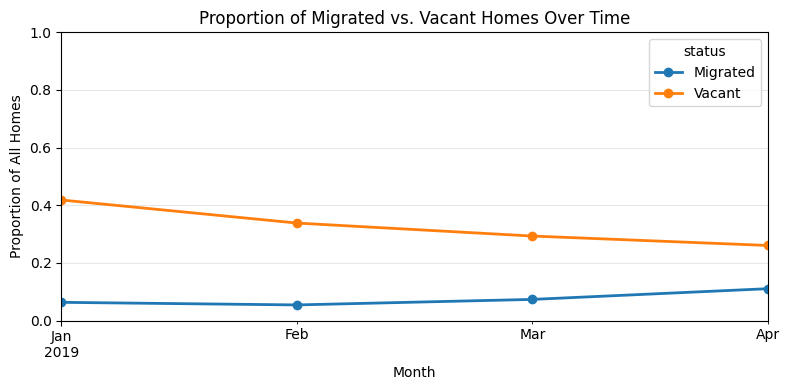

In [25]:
def plot_home_status_ratio_trend(
    folder: str = "",
    migrated_pattern: str = "Migrated_home*.csv",
    vacant_pattern: str = "Vacant_home*.csv",
    total_households: int = None
) -> pd.DataFrame:
    """
    Read Migrated_home*.csv and Vacant_home*.csv, compute monthly proportions
    of each status among all households, and plot the trend.

    Parameters
    ----------
    folder : str
        Directory containing the CSV files.
    migrated_pattern : str
        Filename pattern for migrated home CSVs.
    vacant_pattern : str
        Filename pattern for vacant home CSVs.
    total_households : int
        Total number of households. If None, auto-calculated from all unique home_geohash_8 values.

    Returns
    -------
    ratio_df : pd.DataFrame
        Index: dates; Columns: ['Migrated', 'Vacant']; Values: proportions (0 to 1).
    """
    status_patterns = {
        "Migrated": migrated_pattern,
        "Vacant": vacant_pattern,
    }

    # Step 1: Read all status files and count unique homes
    records = []
    all_home_ids = set()
    for status, pattern in status_patterns.items():
        for file_path in sorted(Path(folder).glob(pattern)):
            print(file_path)
            date_str = file_path.stem.split("home")[-1]  # e.g. "2019-01-01"
            date = pd.to_datetime(date_str)
            df = pd.read_csv(file_path)
            home_ids = df["home_geohash_8"].unique()
            count = len(home_ids)
            records.append({
                "date": date,
                "status": status,
                "count": count
            })
            all_home_ids.update(home_ids)
    print(records)
    trend_df = (
        pd.DataFrame(records)
        .pivot(index="date", columns="status", values="count")
        .sort_index()
    )

    # Step 2: Determine total households
    if total_households is None:
        total_households = len(all_home_ids)

    # Step 3: Compute proportions
    ratio_df = trend_df.div(total_households)

    # Step 4: Plot
    plt.figure(figsize=(8, 4))
    ratio_df.plot(marker="o", linewidth=2, ax=plt.gca())
    plt.title("Proportion of Migrated vs. Vacant Homes Over Time")
    plt.xlabel("Month")
    plt.ylabel("Proportion of All Homes")
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('states_change.png')
    plt.show()

    return ratio_df

num_unique_homes = mapping_df['home_geohash_8'].nunique()
ratio_df = plot_home_status_ratio_trend(migrated_pattern="household_states/Migrated_home*.csv", vacant_pattern= "household_states/Vacant_home*.csv", total_households=num_unique_homes)

In [29]:
# ────────────────────────────────────────────────────────────
df_edges_original = pd.read_csv('home_tables/Household_social_network_2019-01-01.csv')
home_device_count = {}
for _, row in df_edges_original.iterrows():
    home_device_count[row['home_1']] = row['home_1_number']
    home_device_count[row['home_2']] = row['home_2_number']

# Method 2: pandas concat
s1 = (
    df_edges_original[['home_1', 'home_1_number']]
    .drop_duplicates()
    .set_index('home_1')['home_1_number']
)
s2 = (
    df_edges_original[['home_2', 'home_2_number']]
    .drop_duplicates()
    .set_index('home_2')['home_2_number']
)
home_device_count = pd.concat([s1, s2]).to_dict()

# ────────────────────────────────────────────────────────────

# ───────────── 1. Decode all household nodes (Geohash→Lat/Lon) ─────────────
all_home_geohashes = pd.unique(df_edges_original[['home_1', 'home_2']].values.ravel('K'))
print('Number of Household Nodes:', len(all_home_geohashes))
home_centers_data = []
for hid in all_home_geohashes:
    try:
        lat, lon = pgh.decode(hid)
        home_centers_data.append({
            "home_geohash_8": hid,
            "home_latitude":  lat,
            "home_longitude": lon
        })
    except Exception as e:
        print(f"Failed to decode '{hid}': {e}")

home_centers = pd.DataFrame(home_centers_data)

# ───────────── Bounding Area ─────────────

south = min_lat
north = max_lat
west =  min_lon
east =  max_lon

home_centers = home_centers[
    (home_centers['home_latitude' ].between(south, north)) &
    (home_centers['home_longitude'].between(west,  east ))
].reset_index(drop=True)

# Generate dictionary & device count
home_center_dict  = dict(zip(home_centers['home_geohash_8'],
                             zip(home_centers['home_latitude'],
                                 home_centers['home_longitude'])))

# ───────────── 3. Filter edges: keep only if both ends are inside bounding box ─────────────
valid_nodes = set(home_centers['home_geohash_8'])

# --- Optional: sample to reduce density before or after this point
bridging_keep_fraction = 0.1
bonding_keep_fraction  = 0.1

df_edges_bridging = df_edges_original[df_edges_original['type'] == 0]
df_edges_bonding  = df_edges_original[df_edges_original['type'] == 1]

df_edges_bridging = df_edges_bridging.sample(frac=bridging_keep_fraction,
                                             random_state=42)
df_edges_bonding  = df_edges_bonding.sample(frac=bonding_keep_fraction,
                                             random_state=42)

df_edges_filtered = pd.concat([df_edges_bridging, df_edges_bonding], ignore_index=True)

# → Keep only edges where both nodes are valid
df_edges_filtered = df_edges_filtered[
    df_edges_filtered['home_1'].isin(valid_nodes) &
    df_edges_filtered['home_2'].isin(valid_nodes)
].reset_index(drop=True)

print(f"Edge count: {len(df_edges_original)}")
print(f"  - Bridging (Type 0): {len(df_edges_bridging)}")
print(f"  - Bonding (Type 1): {len(df_edges_bonding)}")

# ───────────── 4. Draw the map ─────────────
m = folium.Map(location=[(south+north)/2, (west+east)/2],
               zoom_start=10, tiles='CartoDB positron',
               control_scale=True)

# CSS: center and enlarge scale font
css = """
<style>
  .leaflet-bottom.leaflet-left .leaflet-control-scale {
    left: 50% !important; transform: translateX(-50%)!important;
    font-size:25pt;
  }
  .leaflet-control-scale-line { width: 200px !important; }
</style>
"""
m.get_root().html.add_child(Element(css))

# MiniMap & Mouse coordinates
MiniMap(toggle_display=True, position='bottomright').add_to(m)
MousePosition(position='topright', separator=' ',
              prefix='Coordinates', num_digits=5).add_to(m)

# —— Nodes
for hid, (lat, lon) in home_center_dict.items():
    cnt = home_device_count.get(hid, 1)
    folium.CircleMarker(
        location=[lat, lon],
        radius=3 + cnt * 2,
        color='navy', fill=True, fill_color='cyan', fill_opacity=0.6,
        popup=f"Home: {hid}<br>Devices: {cnt}<br>({lat:.5f}, {lon:.5f})"
    ).add_to(m)

# —— Edges
edge_scale = 1
for _, row in df_edges_filtered.iterrows():
    h1, h2 = row['home_1'], row['home_2']
    p1, p2 = home_center_dict[h1], home_center_dict[h2]
    color = 'darkgreen' if row['type'] == 1 else 'crimson'
    folium.PolyLine(
        [p1, p2],
        weight=max(3, row['avg_link'] * edge_scale),
        color=color, opacity=0.7,
        popup=f"{h1} ↔ {h2}<br>avg_link: {row['avg_link']:.2f}"
    ).add_to(m)

# —— Legend
legend_html = """
<div style="
    position: fixed; bottom: 730px; left: 10px; width: 200px;
    padding: 10px; border: 2px solid gray; background: white;
    z-index:9999; font-size:20px;">
  <div style="margin-bottom:6px;">
    <i style="background:cyan;border:2px solid navy;border-radius:50%;
              width:12px;height:12px;display:inline-block;margin-right:6px;"></i>
    Household node
  </div>
  <div style="margin-bottom:6px;">
    <svg width="20" height="6" style="vertical-align:middle;margin-right:6px;">
      <line x1="0" y1="3" x2="20" y2="3" style="stroke:crimson;stroke-width:3"/>
    </svg>
    Bridging links
  </div>
  <div>
    <svg width="20" height="6" style="vertical-align:middle;margin-right:6px;">
      <line x1="0" y1="5" x2="20" y2="3" style="stroke:darkgreen;stroke-width:3"/>
    </svg>
    Bonding links
  </div>
</div>
"""
m.get_root().html.add_child(Element(legend_html))

LayerControl(collapsed=True).add_to(m)

outfile = 'network_map_clipped.html'
m.save(outfile)
print(f"✅ Map saved to {outfile}")
m


Number of Household Nodes: 887
Edge count: 5000
  - Bridging (Type 0): 450
  - Bonding (Type 1): 50
✅ Map saved to network_map_clipped.html


# Household States Visulization

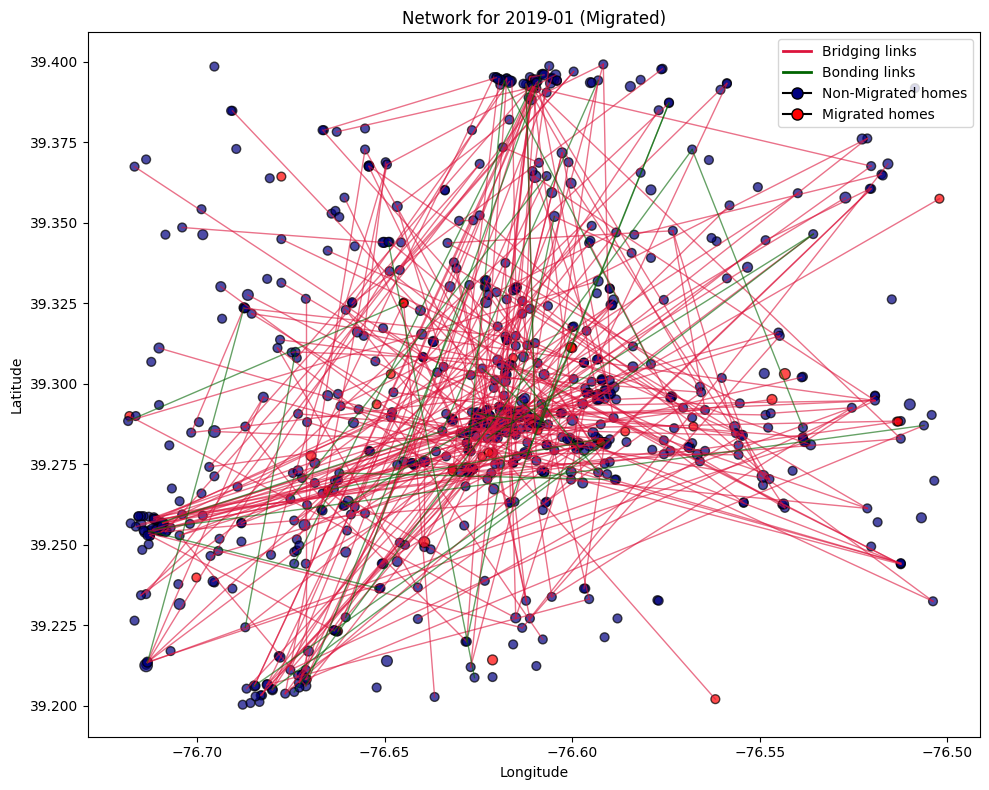

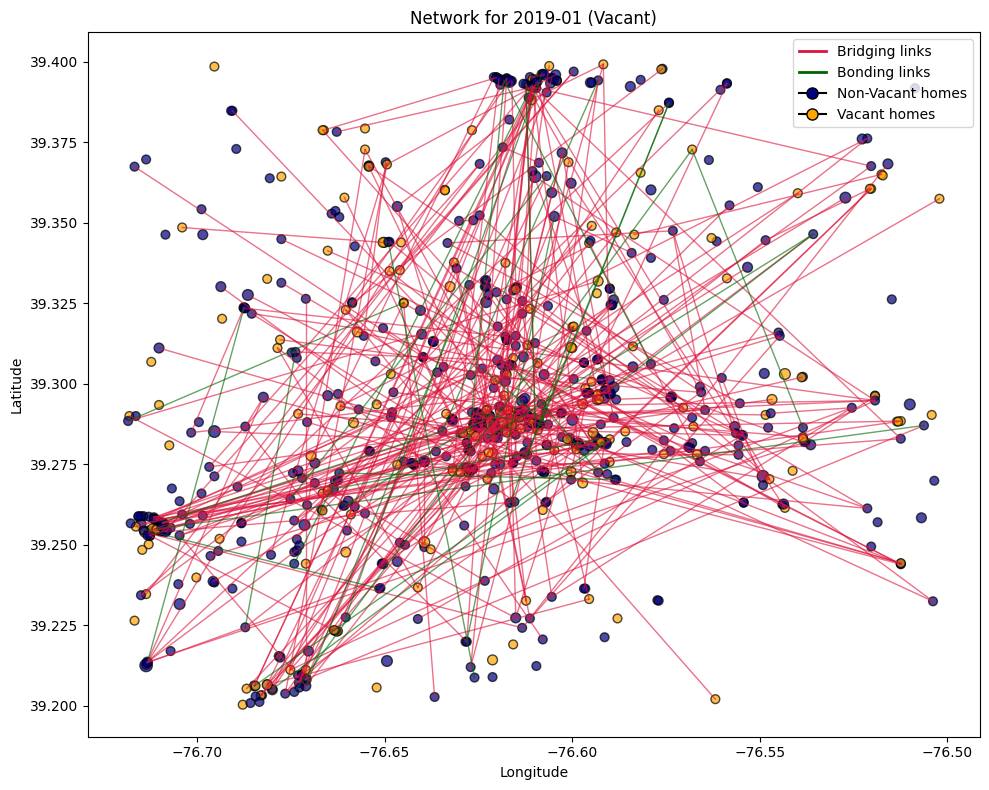

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_network_for_month_status(
    df_edges: pd.DataFrame,
    home_center_dict: dict,
    home_device_count: dict,
    status_csv_path: str,
    status_label: str = "Migrated",
    status_color: str = "red",
    base_node_size: float = 20.0,
    node_size_scale: float = 5.0
):
    """
    Plot the network for a single month, highlighting homes of a given status
    (e.g., migrated or vacant) in a distinct color, and scaling node sizes.

    Parameters
    ----------
    df_edges : pd.DataFrame
        Edge list with columns ['home_1','home_2','type'].
    home_center_dict : dict
        Mapping from home_geohash to (lat, lon).
    home_device_count : dict
        Mapping from home_geohash to number of devices/people.
    status_csv_path : str
        Path to the monthly status file (Migrated_home...csv or Vacant_home...csv).
    status_label : str
        Label for status (e.g., "Migrated" or "Vacant") used in legend.
    status_color : str
        Color to use for the status nodes.
    base_node_size : float
        Constant base size for all nodes.
    node_size_scale : float
        Multiplier for each device count on top of base_node_size.
    """
    # 1) Load status homes this month
    status_df = pd.read_csv(status_csv_path)
    status_set = set(status_df['home_geohash_8'])

    # 2) Filter edges with valid endpoints
    valid_mask = df_edges['home_1'].isin(home_center_dict) & df_edges['home_2'].isin(home_center_dict)
    df = df_edges[valid_mask].reset_index(drop=True)

    # 3) Plot edges
    plt.figure(figsize=(10, 8))
    for _, row in df.iterrows():
        lat1, lon1 = home_center_dict[row['home_1']]
        lat2, lon2 = home_center_dict[row['home_2']]
        edge_color = 'crimson' if row['type'] == 0 else 'darkgreen'
        plt.plot([lon1, lon2], [lat1, lat2], color=edge_color, alpha=0.6, linewidth=1)

    # 4) Plot nodes with status color and size
    longs, lats, colors, sizes = [], [], [], []
    for hid, (lat, lon) in home_center_dict.items():
        if hid not in home_device_count:
            continue
        longs.append(lon)
        lats.append(lat)
        # size = base + scale * device count
        sizes.append(base_node_size + home_device_count[hid] * node_size_scale)
        colors.append(status_color if hid in status_set else 'navy')

    plt.scatter(longs, lats, s=sizes, c=colors, alpha=0.7, edgecolors='black')

    # 5) Legend
    legend_entries = [
        Line2D([0], [0], color='crimson', lw=2, label='Bridging links'),
        Line2D([0], [0], color='darkgreen', lw=2, label='Bonding links'),
        Line2D([0], [0], marker='o', color='black', markerfacecolor='navy',
               markersize=8, label=f'Non-{status_label} homes'),
        Line2D([0], [0], marker='o', color='black', markerfacecolor=status_color,
               markersize=8, label=f'{status_label} homes'),
    ]
    plt.legend(handles=legend_entries, loc='upper right')

    # 6) Labels & title
    month_str = status_csv_path.split(status_label + "_home")[-1].replace(".csv", "")
    plt.title(f'Network for {month_str} ({status_label})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

# Example usage for Migrated:
plot_network_for_month_status(
    df_edges_filtered, home_center_dict, home_device_count,
    'household_states/Migrated_home2019-01.csv',
    status_label='Migrated', status_color='red',
    base_node_size=30, node_size_scale=10
)

# Example usage for Vacant (with larger base size):
plot_network_for_month_status(
    df_edges_filtered, home_center_dict, home_device_count,
    'household_states/Vacant_home2019-01.csv',
    status_label='Vacant', status_color='orange',
    base_node_size=30, node_size_scale=10
)

In [22]:
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

def animate_status_over_time(
    df_edges: pd.DataFrame,
    home_center: dict,
    home_device_count: dict,
    migrated_pattern: str,
    vacant_pattern: str,
    out_gif: str = "network_status.gif",
    base_size: float = 20.0,
    size_scale: float = 5.0,
    interval_ms: int = 1200
):
    """
    Create a GIF/MP4 animation that shows month-by-month status (Migrated / Vacant)
    on top of a fixed household network.

    Parameters
    ----------
    df_edges : DataFrame
        Must contain ['home_1','home_2','type'].
    home_center : dict
        home_geohash -> (lat, lon)
    home_device_count : dict
        home_geohash -> device/people count (node size factor)
    migrated_pattern : str
        Glob such as "household_states/Migrated_home*.csv"
    vacant_pattern : str
        Glob such as "household_states/Vacant_home*.csv"
    out_gif : str
        File name for saved animation (gif). Use ".mp4" for mp4 (needs ffmpeg).
    base_size / size_scale : float
        Node size = base_size + size_scale * device_count.
    interval_ms : int
        Delay between frames (milliseconds).
    """
    # --------------------------------------------
    # 1. Load all monthly status sets
    # --------------------------------------------
    def get_set(pattern):
        files = sorted(glob.glob(pattern))
        info = {}
        for fp in files:
            date_str = Path(fp).stem.split("home")[-1].lstrip("_")
            date = pd.to_datetime(date_str)
            homes = pd.read_csv(fp)["home_geohash_8"].unique()
            info[date] = set(homes)
        return info

    mig_dict = get_set(migrated_pattern)
    vac_dict = get_set(vacant_pattern)

    # Common sorted timeline
    months = sorted(set(mig_dict) | set(vac_dict))
    if not months:
        raise ValueError("No status files matched the given patterns.")

    # --------------------------------------------
    # 2. Build static edge plot
    # --------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 8))
    for _, row in df_edges.iterrows():
        lat1, lon1 = home_center[row["home_1"]]
        lat2, lon2 = home_center[row["home_2"]]
        edge_col = "crimson" if row["type"] == 0 else "darkgreen"
        ax.plot([lon1, lon2], [lat1, lat2], color=edge_col, alpha=0.6, lw=1)

    # Pre-compute node positions & sizes
    xs, ys, sizes = [], [], []
    home_order = []  # keep consistent ordering
    for hid, (lat, lon) in home_center.items():
        if hid not in home_device_count:    # skip if no size info
            continue
        xs.append(lon)
        ys.append(lat)
        sizes.append(base_size + size_scale * home_device_count[hid])
        home_order.append(hid)

    scat = ax.scatter(xs, ys, s=sizes, c="navy", alpha=0.7, edgecolors="black")
    time_txt = ax.text(0.02, 0.96, "", transform=ax.transAxes,
                       ha="left", va="top", fontsize=14)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Monthly Migration & Vacancy Dynamics")

    # Legend
    legend_items = [
        Line2D([0], [0], color="crimson", lw=2, label="Bridging links"),
        Line2D([0], [0], color="darkgreen", lw=2, label="Bonding links"),
        Line2D([0], [0], marker="o", color="black",
               markerfacecolor="navy", markersize=8, label="Normal"),
        Line2D([0], [0], marker="o", color="black",
               markerfacecolor="red", markersize=8, label="Migrated"),
        Line2D([0], [0], marker="o", color="black",
               markerfacecolor="orange", markersize=8, label="Vacant")
    ]
    ax.legend(handles=legend_items, loc="upper right")

    # --------------------------------------------
    # 3. Animation update function
    # --------------------------------------------
    def update(frame_idx):
        date = months[frame_idx]
        mig_set = mig_dict.get(date, set())
        vac_set = vac_dict.get(date, set())

        colors = []
        for hid in home_order:
            if hid in mig_set:
                colors.append("red")
            elif hid in vac_set:
                colors.append("orange")
            else:
                colors.append("navy")
        scat.set_color(colors)
        time_txt.set_text(date.strftime("%Y-%m"))
        return scat, time_txt

    anim = FuncAnimation(
        fig, update, frames=len(months), blit=True,
        interval=interval_ms, repeat=True
    )

    # --------------------------------------------
    # 4. Save animation
    # --------------------------------------------
    if out_gif.lower().endswith(".gif"):
        anim.save(out_gif, writer="pillow", dpi=120)
    else:  # assume mp4
        anim.save(out_gif, writer="ffmpeg", dpi=120)

    plt.close(fig)
    print(f"✅ Animation saved to {out_gif}")


animate_status_over_time(
    df_edges_filtered,
    home_center_dict,
    home_device_count,
    migrated_pattern="household_states/Migrated_home*.csv",
    vacant_pattern="household_states/Vacant_home*.csv",
    out_gif="network_status.gif",   # or "network_status.mp4"
    base_size=30,
    size_scale=10,
    interval_ms=1200
)

✅ Animation saved to network_status.gif


In [18]:
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

def animate_single_status(
    df_edges: pd.DataFrame,
    home_center: dict,
    home_device_count: dict,
    status_pattern: str,
    status_label: str,
    status_color: str,
    out_file: str,
    base_size: float = 20,
    size_scale: float = 5,
    interval_ms: int = 1200
):
    """
    Animate ONE status (e.g., Migrated OR Vacant) over time on a fixed network.

    Parameters
    ----------
    status_pattern : str
        Glob pattern, e.g. "household_states/Migrated_home*.csv".
    status_label : str
        "Migrated" or "Vacant" – used in legend/title.
    status_color : str
        Color for status nodes.
    out_file : str
        Output GIF/MP4 filename.
    Other params see previous function.
    """
    # Load monthly status sets
    status_dict = {}
    for fp in sorted(glob.glob(status_pattern)):
        date_str = Path(fp).stem.split("home")[-1].lstrip("_")
        date = pd.to_datetime(date_str)
        status_dict[date] = set(pd.read_csv(fp)["home_geohash_8"].unique())

    months = sorted(status_dict)
    if not months:
        raise ValueError(f"No files matched {status_pattern}")

    # Static edge plot
    fig, ax = plt.subplots(figsize=(10, 8))
    for _, row in df_edges.iterrows():
        lat1, lon1 = home_center[row["home_1"]]
        lat2, lon2 = home_center[row["home_2"]]
        clr = "crimson" if row["type"] == 0 else "darkgreen"
        ax.plot([lon1, lon2], [lat1, lat2], color=clr, alpha=0.6, lw=1)

    # Node positions & sizes
    xs, ys, sizes, order = [], [], [], []
    for hid, (lat, lon) in home_center.items():
        if hid not in home_device_count:
            continue
        xs.append(lon); ys.append(lat); order.append(hid)
        sizes.append(base_size + size_scale * home_device_count[hid])

    scat = ax.scatter(xs, ys, s=sizes, c="navy", alpha=0.7, edgecolors="black")
    txt  = ax.text(0.02, 0.96, "", transform=ax.transAxes,
                   ha="left", va="top", fontsize=14)

    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    ax.set_title(f"{status_label} Households Over Time")

    legend_handles = [
        Line2D([0],[0], marker="o", color="black",
               markerfacecolor="navy",   markersize=8, label="Normal"),
        Line2D([0],[0], marker="o", color="black",
               markerfacecolor=status_color, markersize=8, label=status_label)
    ]
    ax.legend(handles=legend_handles, loc="upper right")


    def update(i):
        date = months[i]
        active = status_dict[date]
        colors = [status_color if h in active else "navy" for h in order]
        scat.set_color(colors)
        txt.set_text(date.strftime("%Y-%m"))
        return scat, txt

    anim = FuncAnimation(fig, update, frames=len(months),
                         interval=interval_ms, blit=True, repeat=True)

    if out_file.lower().endswith(".gif"):
        anim.save(out_file, writer="pillow", dpi=120)
    else:
        anim.save(out_file, writer="ffmpeg", dpi=120)

    plt.close(fig)
    print(f"✅ Saved {status_label} animation to {out_file}")

# Migrated
animate_single_status(
    df_edges_filtered,
    home_center_dict,
    home_device_count,
    status_pattern="household_states/Migrated_home*.csv",
    status_label="Migrated",
    status_color="red",
    out_file="migrated_only.gif",
    base_size=30,
    size_scale=10
)

# Vacant
animate_single_status(
    df_edges_filtered,
    home_center_dict,
    home_device_count,
    status_pattern="household_states/Vacant_home*.csv",
    status_label="Vacant",
    status_color="orange",
    out_file="vacant_only.gif",
    base_size=30,
    size_scale=10
)

✅ Saved Migrated animation to migrated_only.gif
✅ Saved Vacant animation to vacant_only.gif


# Only need to run when there are files missing

In [ ]:
def identify_home_locations(df, min_appearances=7, night_start_hour=23, night_end_hour=6,
                            min_home_visits=3, location_precision=3, w1=0.6, w2=0.4):
    """
    Identify home locations for each device using (primarily) night-time visits.
    If a device has *no* night-time data, its day-time data are used instead.
    """
    result_df = df.copy()

    # --- 1. Preprocessing ----------------------------------------------------------
    if not pd.api.types.is_datetime64_any_dtype(result_df['timestamp_2']):
        result_df['timestamp_2'] = pd.to_datetime(result_df['timestamp_2'])

    # Keep only devices with sufficient appearances
    device_counts = result_df['device_id'].value_counts()
    valid_devices = device_counts[device_counts >= min_appearances].index
    result_df = result_df[result_df['device_id'].isin(valid_devices)]

    # Round lat/lon to given precision as spatial cell
    result_df['location_cell'] = (
        result_df['latitude_2'].round(location_precision).astype(str) + '_' +
        result_df['longitude_2'].round(location_precision).astype(str)
    )

    # Extract hour and date from timestamp
    result_df['hour'] = result_df['timestamp_2'].dt.hour
    result_df['date'] = result_df['timestamp_2'].dt.date

    # --- 2. Keep only night-time visits --------------------------------------------
    if night_start_hour > night_end_hour:  # Crosses midnight
        night_mask = (result_df['hour'] >= night_start_hour) | (result_df['hour'] < night_end_hour)
    else:  # Does not cross midnight
        night_mask = (result_df['hour'] >= night_start_hour) & (result_df['hour'] < night_end_hour)

    night_visits = result_df[night_mask].copy()

    # Find devices without any night-time visits → use their daytime data as fallback
    all_devices = set(result_df['device_id'].unique())
    night_devices = set(night_visits['device_id'].unique())
    devices_no_night = all_devices - night_devices

    if devices_no_night:
        backup_visits = result_df[result_df['device_id'].isin(devices_no_night)].copy()
        night_visits = pd.concat([night_visits, backup_visits], ignore_index=True)

    # --- 3. Count visits per location per device -----------------------------------
    visit_counts = (
        night_visits
        .groupby(['device_id', 'location_cell'])
        .size()
        .reset_index(name='visits')
    )

    home_candidates = visit_counts[visit_counts['visits'] >= min_home_visits].copy()

    # If a device has no location reaching the threshold → choose most visited location
    missing_dev = all_devices - set(home_candidates['device_id'].unique())
    if missing_dev:
        fallback = (
            visit_counts[visit_counts['device_id'].isin(missing_dev)]
            .sort_values(['device_id', 'visits'], ascending=[True, False])
            .groupby('device_id')
            .head(1)
        )
        home_candidates = pd.concat([home_candidates, fallback], ignore_index=True)

    # --- 4. Compute temporal consistency -------------------------------------------
    distinct_days = (
        night_visits
        .groupby(['device_id', 'location_cell'])['date']
        .nunique()
        .reset_index(name='distinct_days')
    )
    total_days = max((result_df['date'].max() - result_df['date'].min()).days + 1, 1)

    home_candidates = home_candidates.merge(distinct_days, on=['device_id', 'location_cell'], how='left')
    home_candidates['distinct_days'] = home_candidates['distinct_days'].fillna(1)
    home_candidates['temporal_consistency'] = home_candidates['distinct_days'] / total_days

    # --- 5. Compute weighted score (penalize daytime-only data) --------------------
    penalty_mask = home_candidates['device_id'].isin(devices_no_night)

    home_candidates['score'] = np.where(
        penalty_mask,
        w1 * home_candidates['visits'] * 0.5 + w2 * home_candidates['temporal_consistency'] * 0.5,
        w1 * home_candidates['visits']       + w2 * home_candidates['temporal_consistency']
    )

    # --- 6. Select the best-scored location for each device ------------------------
    best_locations = home_candidates.loc[
        home_candidates.groupby('device_id')['score'].idxmax()
    ][['device_id', 'location_cell', 'score']]

    # Retrieve original latitude and longitude of the selected location
    loc_samples = (
        night_visits
        .groupby(['device_id', 'location_cell'])
        .agg({'latitude_2': 'first', 'longitude_2': 'first'})
        .reset_index()
    )

    home_locations = best_locations.merge(loc_samples, on=['device_id', 'location_cell'])
    home_locations = home_locations.rename(
        columns={'latitude_2': 'home_latitude', 'longitude_2': 'home_longitude'}
    )[['device_id', 'home_latitude', 'home_longitude']]

    # --- 7. Merge home locations back to the original dataframe ---------------------
    result_df = result_df.merge(home_locations, on='device_id', how='left')
    result_df = result_df.drop(columns=['hour', 'date', 'location_cell'])

    return result_df

result_df_with_homes = identify_home_locations(linked_df)
# 1. Encode home_latitude and home_longitude into a 9-character Geohash
result_df_with_homes["home_geohash_8"] = result_df_with_homes.apply(
    lambda row: geohash.encode(row["home_latitude"], row["home_longitude"], precision=8),
    axis=1
)

# 2. Decode the 9-character Geohash to the center point (lat, lon) of the grid
#    decode() returns a tuple (center_lat, center_lon)
result_df_with_homes["home_center"] = result_df_with_homes["home_geohash_8"].apply(geohash.decode)

# 3. Split the tuple into two columns: home_latitude_8, home_longitude_8
result_df_with_homes["home_latitude_8"] = result_df_with_homes["home_center"].apply(lambda x: x[0])
result_df_with_homes["home_longitude_8"] = result_df_with_homes["home_center"].apply(lambda x: x[1])

# 4. If the intermediate column home_center is no longer needed, delete it
result_df_with_homes.drop(columns=["home_center"], inplace=True)

# Select the columns to retain
cols_to_keep = ['device_id', 'home_latitude', 'home_longitude',
                'home_geohash_8', 'home_latitude_8', 'home_longitude_8']

# Extract these columns and remove duplicate device_id entries
result_df_subset = result_df_with_homes[cols_to_keep].copy().drop_duplicates(subset=['device_id'])

# home_latitude_8, home_longitude_8 are center coordinate of the grid cell by geohash, home_latitude, home_longitude are orginal home coordinate
print("Number of home count:", result_df_subset['device_id'].nunique())

result_df_subset.to_csv(f"user_home_relation_{start_date.date()}.csv", index=False)


Number of home count: 1070
